In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
# Constants
LAYER_RADII = [2.5, 5.0]  # VTX Layer 0 and 1 in cm
SDPHI = 0.02
SDTHE = 0.05

beam=(0.35, 0.04, 0)
sigma_vertex = 0.0045
n_traks = 100

# --- VTX Radii (cm): B0, B1, B2a, B2b, B2c, B3a, B3b, B3c ---
VTX_RADII = np.array([2.64, 5.22, 10.41, 11.80, 12.90, 15.55, 16.74, 17.91])

# --- Detector spatial resolution (cm) ---
# Pixel: B0–B1, Stripixel: B2–B3
PIXEL_SIZE_PHI = 0.005
PIXEL_SIZE_Z   = 0.0425
STRIP_SIZE_PHI = 0.008
STRIP_SIZE_Z   = 0.10

# Convert to resolution (RMS of uniform distribution)
def uniform_rms(pitch):
    return pitch / np.sqrt(12)

VTX_RESOLUTIONS = []
for i, r in enumerate(VTX_RADII):
    if i < 2:  # Pixel layers
        dphi = uniform_rms(PIXEL_SIZE_PHI)
        dz = uniform_rms(PIXEL_SIZE_Z)
    else:      # Stripixel layers
        dphi = uniform_rms(STRIP_SIZE_PHI)
        dz = uniform_rms(STRIP_SIZE_Z)
    VTX_RESOLUTIONS.append((dphi, dz))

In [ ]:
def generate_tracks_full(pt, event_vertex=(0.35, 0.04, 0.0), itrack=0):
    all_hits = [[] for _ in range(4)]  # B0, B1, B2, B3
    pt_list = []

    x0, y0, z0 = event_vertex

    pt_list.append(pt)
    R = pt / (0.003 * 0.9)  # pT to radius (cm)

    eta = np.random.uniform(-0.5, 0.5)
    theta = 2 * np.arctan(np.exp(-eta))
    phi0 = np.random.uniform(0, 2 * np.pi)
    charge = np.random.choice([-1, 1])

    # Determine helix circle center in XY
    cx = x0 + charge * R * np.sin(phi0)
    cy = y0 - charge * R * np.cos(phi0)

    layer_map = {
        0: 0,
        1: 1,
        2: np.random.choice([2, 3, 4]),
        3: np.random.choice([5, 6, 7])
    }

    #print(f"Track {itrack}: pT = {pt:.3f}, circle center = ({cx:.3f}, {cy:.3f}), R = {R:.3f}")

    for ilayer, sl in layer_map.items():
        radius = VTX_RADII[sl]
        dphi = charge * radius / R
        phi = phi0 + dphi

        # Unsmeared hit
        x_true = cx - charge * R * np.sin(phi)
        y_true = cy + charge * R * np.cos(phi)
        z_true = z0 + radius / np.tan(theta)

        # Residual from true helix
        r2 = (x_true - cx)**2 + (y_true - cy)**2
        residual_before = abs(np.sqrt(r2) - R)

        # Apply detector resolution smearing
        res_phi, res_z = VTX_RESOLUTIONS[sl]
        smear_phi = np.random.normal(0, res_phi)
        smear_z = np.random.normal(0, res_z)

        # Apply additional multiple scattering smearing (assuming pions)
        # crude MCS estimate ~ 13.6 MeV / (beta * p) * sqrt(x/X0)
        # We approximate sqrt(x/X0) with a constant since layer material is unknown
        additional_smear_phi = np.random.normal(0, 0.003 / pt)  # 3 mrad/pT rough estimate

        x_smear = x_true + smear_phi * (-np.sin(phi+additional_smear_phi))
        y_smear = y_true + smear_phi * (np.cos(phi+additional_smear_phi))
        z_smear = z_true + smear_z

        r2_smear = (x_smear - cx)**2 + (y_smear - cy)**2
        residual_after = abs(np.sqrt(r2_smear) - R)

        #print(f"  Layer B{ilayer}: residual before = {residual_before:.2e} cm, after = {residual_after:.2e} cm")

        all_hits[ilayer].append((x_smear, y_smear, z_smear, phi, theta, itrack))

    return all_hits, pt_list, [x0, y0, z0]


In [31]:
def fit_circle(x1, y1, x2, y2, x3, y3):
    """Fit circle through 3 points in XY and return (xc, yc, R)"""
    temp = x2**2 + y2**2
    bc = (x1**2 + y1**2 - temp) / 2.0
    cd = (temp - x3**2 - y3**2) / 2.0
    det = (x1 - x2) * (y2 - y3) - (x2 - x3) * (y1 - y2)

    if abs(det) < 1e-6:
        return None, None, None  # Degenerate configuration

    cx = (bc * (y2 - y3) - cd * (y1 - y2)) / det
    cy = ((x1 - x2) * cd - (x2 - x3) * bc) / det
    R = np.sqrt((x1 - cx)**2 + (y1 - cy)**2)
    return cx, cy, R


def intersect_circles(x0, y0, r0, x1, y1, r1):
    dx = x1 - x0
    dy = y1 - y0
    d = np.hypot(dx, dy)

    # No solution cases
    if d > r0 + r1:
        return []  # too far apart
    if d < abs(r0 - r1):
        return []  # one inside the other
    if d == 0 and r0 == r1:
        return []  # infinite intersections

    # Find point P2
    a = (r0**2 - r1**2 + d**2) / (2 * d)
    h = np.sqrt(r0**2 - a**2)
    x2 = x0 + a * dx / d
    y2 = y0 + a * dy / d

    rx = -dy * (h / d)
    ry = dx * (h / d)

    p1 = (x2 + rx, y2 + ry)
    p2 = (x2 - rx, y2 - ry)

    return [p1, p2]

def delta_phi(phi1, phi2):
    return np.abs(np.arctan2(np.sin(phi1 - phi2), np.cos(phi1 - phi2)))

In [32]:
# Cell 5: Track Circle Reconstruction with Hit Chaining and Statistics

def track_circle_analysis(hits_per_layer, true_pt_list, beam=(0.35, 0.04, 0),
                          sdphi=0.05, sdthe=0.02, match_window=0.2, real_vertex=(0.35, 0.04,0)):
    matched_pts = []
    reco_pts = []
    all_circles = []

    total_b0_hits = len(hits_per_layer[0])
    used_b0_hits = 0
    track_chains = 0
    all_chain_candidates = 0
    true_triplets = 0

    for i, hit1 in enumerate(hits_per_layer[0]):  # B0 hits
        x1, y1, z1, phi1, theta1, track_id1 = hit1
        r1 = np.hypot(x1 - beam[0], y1 - beam[1])
        phi1 = np.arctan2(y1 - beam[1], x1 - beam[0])
        the1 = np.arctan2(r1, z1 - beam[2])

        candidate_b1_hits = []
        for hit2 in hits_per_layer[1]:
            x2, y2, z2, phi2, theta2, track_id2 = hit2
            r2 = np.hypot(x2 - beam[0], y2 - beam[1])
            phi2 = np.arctan2(y2 - beam[1], x2 - beam[0])
            the2 = np.arctan2(r2, z2 - beam[2])

            dphi = delta_phi(phi1, phi2)
            dtheta = abs(the1 - the2)

            if dphi < sdphi and dtheta < sdthe:
                candidate_b1_hits.append(hit2)

        if len(candidate_b1_hits) == 0:
            continue

        best_triplet = None
        min_total_dist = float('inf')

        for hit2 in candidate_b1_hits:
            cx, cy, R = fit_circle(beam[0], beam[1], x1, y1, hit2[0], hit2[1])
            if R is None:
                continue
            phi_arc = np.arctan2(hit2[1] - cy, hit2[0] - cx)

            for hit3 in hits_per_layer[2]:
                x3, y3, z3, _, _, track_id3 = hit3
                r3 = np.hypot(x3, y3)
                intersections = intersect_circles(cx, cy, R, 0, 0, r3)
                if not intersections:
                    continue
                best_proj = min(intersections, key=lambda p: delta_phi(np.arctan2(p[1], p[0]), phi_arc))
                dist = np.hypot(x3 - best_proj[0], y3 - best_proj[1])
                if dist < match_window and dist < min_total_dist:
                    best_triplet = (hit2, hit3)
                    min_total_dist = dist

        if best_triplet is None:
            continue

        hit2, hit3 = best_triplet
        xc, yc, R = fit_circle(x1, y1, hit2[0], hit2[1], hit3[0], hit3[1])
        if xc is None or yc is None:
            continue
        
        #print(f"Track {i}: Circle center: ({xc:.2f}, {yc:.2f}), Radius: {R:.2f}, residual: {abs((real_vertex[0]-xc)**2+(real_vertex[1]-yc)**2 - R**2)**0.5:.2e}\
        #      , x: { (R**2-(real_vertex[1]-yc)**2)**0.5 +xc-real_vertex[0]:.2e}")
        all_circles.append((xc, yc, R))
        used_b0_hits += 1
        track_chains += 1

        pt_reco = R * (0.003 * 0.9)
        pt_true = true_pt_list[i]
        delta_p = (pt_reco - pt_true) / pt_true
        reco_pts.append([pt_true, delta_p])

        matched_pts.append((x1, y1, hit2[0], hit2[1], hit3[0], hit3[1]))

        if track_id1 == hit2[5] == hit3[5]:
            true_triplets += 1

    stats = {
        'total_b0': total_b0_hits,
        'used_b0': used_b0_hits,
        'efficiency': used_b0_hits / total_b0_hits if total_b0_hits > 0 else 0,
        'n_tracks': track_chains,
        'total_candidates': all_chain_candidates,
        'precision': true_triplets / track_chains if track_chains > 0 else 0
    }

    return reco_pts, all_circles, matched_pts, stats

In [33]:
# Generate hits and store pt per track
tracks = []
hits_per_layer = [[] for _ in range(4)]
true_pts = []

vetexes = np.random.normal(loc=beam, scale=sigma_vertex, size=3)
print(f"Event vertex: {vetexes}")
for itrack in range(n_traks):
    pt = min(np.random.exponential(scale=0.5) + 0.1, 3.0)
    hits, _, _ = generate_tracks_full(pt=pt, event_vertex=vetexes, itrack=itrack)
    for ilayer in range(4):
        hits_per_layer[ilayer].append(hits[ilayer][0])
    true_pts.append(pt)

# Run analysis
delta_p_vals, circles, _, collected_stat = track_circle_analysis(hits_per_layer, true_pts, real_vertex=vetexes )

Event vertex: [ 0.34814204  0.0314626  -0.003805  ]


In [34]:
# Cell 6: Display collected vertex reconstruction stats

def display_stats(stats):
    print("\n=== Vertex Reconstruction Statistics ===")
    print(f"Total B0 hits:            {stats['total_b0']}")
    print(f"Used B0 hits (tracks):    {stats['used_b0']}")
    print(f"Tracking efficiency:      {100 * stats['efficiency']:.2f}%")
    print(f"Valid tracks reconstructed: {stats['n_tracks']}")
    print(f"Total B0→B1→B2 candidates:  {stats['total_candidates']}")
    print(f"Precision:                {100 * stats['precision']:.2f}%")

# Example usage after track_circle_analysis:
display_stats(collected_stat)


=== Vertex Reconstruction Statistics ===
Total B0 hits:            100
Used B0 hits (tracks):    94
Tracking efficiency:      94.00%
Valid tracks reconstructed: 94
Total B0→B1→B2 candidates:  0
Precision:                81.91%


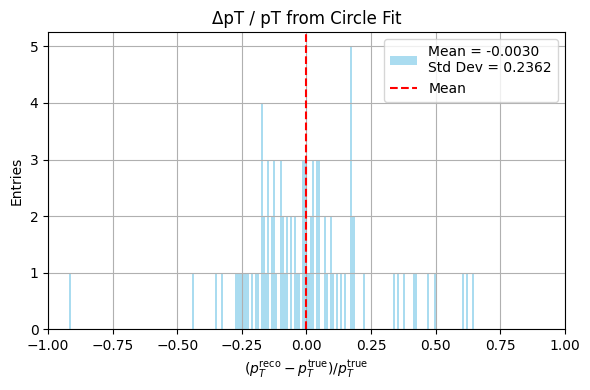

In [35]:
new_delta_p = [delta_p_vals[i][1] for i in range(len(delta_p_vals)) if delta_p_vals[i][1]<1.0 and delta_p_vals[i][1]>-1.0]
# Plot histogram
# Calculate mean and standard deviation
mean_delta_p = np.average(new_delta_p)
stddev_delta_p = np.std(new_delta_p)

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(new_delta_p, bins=200, alpha=0.7, color='skyblue', label=f'Mean = {mean_delta_p:.4f}\nStd Dev = {stddev_delta_p:.4f}')
plt.axvline(mean_delta_p, color='red', linestyle='--', label='Mean')
plt.xlabel(r'$(p_T^{\mathrm{reco}} - p_T^{\mathrm{true}})/p_T^{\mathrm{true}}$')
plt.ylabel('Entries')
plt.title("ΔpT / pT from Circle Fit")
plt.xlim(-1, 1)  # Set x-axis limits
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
def plot_circles_with_hits(circles, hits_per_layer, beam=(0.35, 0.04)):
    fig, ax = plt.subplots(figsize=(9, 9))

    # Draw all fitted circles
    for cx, cy, R in circles:
        theta = np.linspace(0, 2 * np.pi, 200)
        x = cx + R * np.cos(theta)
        y = cy + R * np.sin(theta)
        ax.plot(x, y, alpha=0.3, color='gray')
        
        kek = True
        for ilayer in range(3):
            keks = False
            for hit in hits_per_layer[ilayer]:
                if abs( (cx - hit[0])**2 + (cy - hit[1])**2 - R**2) < 1e-9:
                    keks = True
                    break
            kek = kek and keks
        if not kek: print("No hits on circle!")

    # Plot hits in B0, B1, B2 only
    layer_labels = ['B0', 'B1', 'B2']
    layer_colors = ['purple', 'red', 'blue']

    for i, (label, color) in enumerate(zip(layer_labels, layer_colors)):
        hits = hits_per_layer[i]
        x, y = zip(*[(h[0], h[1]) for h in hits])
        ax.scatter(x, y, label=label, color=color, s=10)

    # Beam position
    ax.plot(*beam, 'ko', label='Beam')

    # Set axis limits to match VTX coverage
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_aspect('equal')
    ax.set_xlabel("X [cm]")
    ax.set_ylabel("Y [cm]")
    ax.set_title("Fitted Circles and VTX Hits (B0–B2)")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

No hits on circle!
No hits on circle!


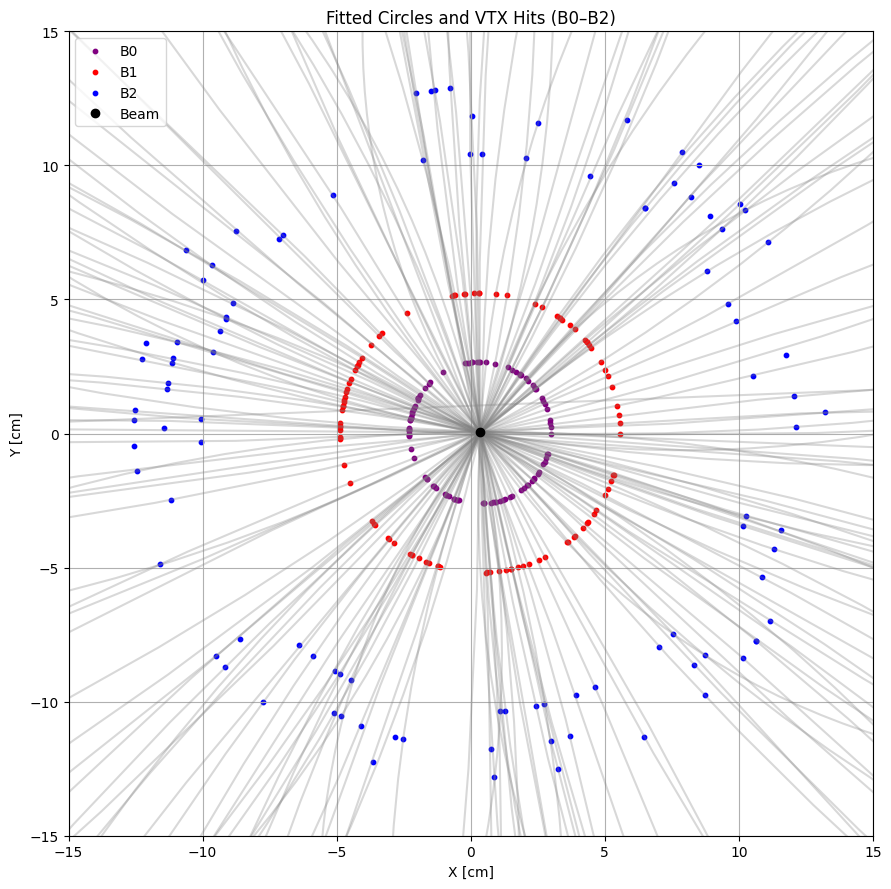

In [37]:
plot_circles_with_hits(circles, hits_per_layer, beam=(0.35, 0.04))

def evaluate_circle_at_y(cx, cy, R, y_target):
    dy = y_target - cy
    if abs(dy) > R:
        return None  # no solution
    dx = np.sqrt(R**2 - dy**2)
    return [cx - dx, cx + dx]  # two x-values

def evaluate_circle_at_x(cx, cy, R, x_target):
    dx = x_target - cx
    if abs(dx) > R:
        return None
    dy = np.sqrt(R**2 - dx**2)
    return [cy - dy, cy + dy]
    

In [38]:
delta_xs = []
delta_ys = []
weights_x = []
weights_y = []

for cx, cy, R in circles:
    # Δx: Evaluate circle at y = beam_y
    dy = beam[1] - cy
    if abs(dy) < R:
        dx = np.sqrt(R**2 - dy**2)
        x_candidates = [cx - dx, cx + dx]
        #delta_xs.append(abs((vetexes[0]-cx)**2+(vetexes[1]-cy)**2 - R**2))
        #delta_xs.append((R**2-(vetexes[1]-cy)**2)**0.5 +cx-vetexes[0])
        x_closest = min(x_candidates, key=lambda x: abs(x - beam[0]))
        delta_xs.append(x_closest - beam[0])

        angle = np.arctan2(dy, x_closest - cx)
        weights_x.append(np.abs(np.cos(angle)))
    
    # Δy: Evaluate circle at x = beam_x
    dx = beam[0] - cx
    if abs(dx) < R:
        dy = np.sqrt(R**2 - dx**2)
        y_candidates = [cy - dy, cy + dy]
        y_closest = min(y_candidates, key=lambda y: abs(y - beam[1]))
        delta_ys.append(y_closest - beam[1])

        # Weight by sin(angle at that point)
        angle = np.arctan2(y_closest - cy, dx)
        weights_y.append(np.abs(np.sin(angle)))

In [39]:
print(f"Delta Xs: {delta_xs}")

Delta Xs: [0.011429462469459417, -0.09072199013747129, -0.006037609438612868, 0.011506430572930548, 0.049970789948554306, -0.012762626236002439, -0.005578894697555348, -0.003779601022222301, -0.06730012069123459, 0.011181217708320923, -0.046679585892312025, -0.006652939164146665, -0.002383570133139279, -0.011570766360547657, 0.013828039899871691, -0.023005169302712125, -0.008152111294100428, 0.15820052411268437, 0.0048221531741902135, -0.03072083637203915, -0.02401512746197143, -0.012272816958953547, 0.041041937157169195, 0.3911135500666042, -0.018792696253291274, -0.03007863974696645, 0.059077923861652004, -0.024169465989052674, -0.016813364901599903, 0.022942196882689836, -0.05278232578533559, 0.038356972851525506, -0.07065708193422038, 0.01266058823872529, 0.5547752524046144, -0.010612797424025877, -0.004010877424752812, 0.09406561101520483, -0.18619556901503598, 0.01193544378440381, 0.018961481008398118, -0.003648724617028143, 0.008364832036272696, -1.0659559327298744, 0.0136997386

In [40]:
def plot_vertex_residuals(delta_xs, delta_ys, vertex, beam):
    dx_mean = np.mean(delta_xs)
    dy_mean = np.mean(delta_ys)
    dx_true = vertex[0] - beam[0]
    dy_true = vertex[1] - beam[1]

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Δx
    ax[0].hist(delta_xs, bins=30, color='orange', alpha=0.7)
    ax[0].axvline(dx_mean, color='red', linestyle='--', label=f"Mean Δx = {dx_mean:.4f}")
    ax[0].axvline(dx_true, color='black', linestyle='-', label=f"True Δx = {dx_true:.4f}")
    ax[0].set_title("Δx at y = beam_y")
    ax[0].set_xlabel("Δx [cm]")
    ax[0].set_ylabel("Entries")
    ax[0].legend()
    ax[0].grid(True)

    # Δy
    ax[1].hist(delta_ys, bins=30, color='skyblue', alpha=0.7)
    ax[1].axvline(dy_mean, color='red', linestyle='--', label=f"Mean Δy = {dy_mean:.4f}")
    ax[1].axvline(dy_true, color='black', linestyle='-', label=f"True Δy = {dy_true:.4f}")
    ax[1].set_title("Δy at x = beam_x")
    ax[1].set_xlabel("Δy [cm]")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

In [41]:
# Weighted mean
mean_dx = np.average(delta_xs, weights=weights_x)
mean_dy = np.average(delta_ys, weights=weights_y)

# Weighted median: sort by delta, then interpolate weighted center
def weighted_median(data, weights):
    sorted_data, sorted_weights = zip(*sorted(zip(data, weights)))
    cumsum = np.cumsum(sorted_weights)
    cutoff = cumsum[-1] / 2.0
    idx = np.searchsorted(cumsum, cutoff)
    return sorted_data[idx]

median_dx = weighted_median(delta_xs, weights_x)
median_dy = weighted_median(delta_ys, weights_y)

def weighted_std(data, weights):
    average = np.average(data, weights=weights)
    variance = np.average((data - average)**2, weights=weights)
    return np.sqrt(variance)

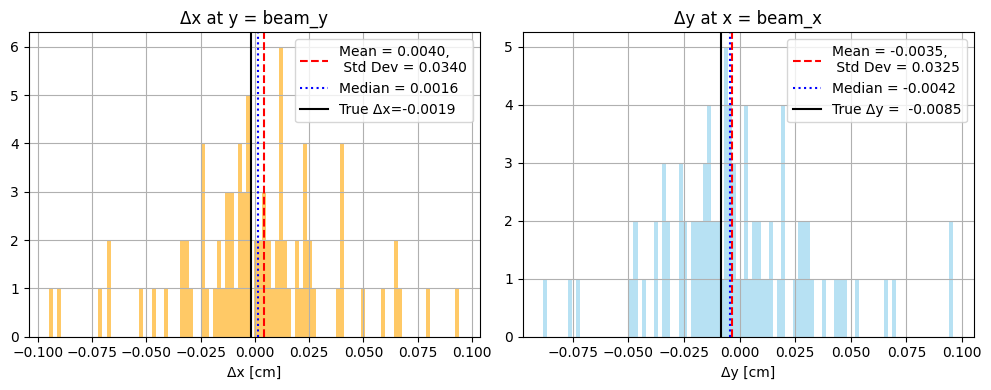

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Δx
delta_xs_plot = [i for i in delta_xs if i > -0.1 and i < 0.1]
delta_ys_plot = [i for i in delta_ys if i > -0.1 and i < 0.1]

# Calculate standard deviations
std_dx = np.std(delta_xs_plot)
std_dy = np.std(delta_ys_plot)

# Δx
ax[0].hist(delta_xs_plot, bins=100, color='orange', alpha=0.6)
ax[0].axvline(mean_dx, color='red', linestyle='--', label=f"Mean = {mean_dx:.4f},\n Std Dev = {std_dx:.4f}")
ax[0].axvline(median_dx, color='blue', linestyle=':', label=f"Median = {median_dx:.4f}")
ax[0].axvline(vetexes[0] - beam[0], color='black', linestyle='-', label='True Δx={:.4f}'.format(vetexes[0] - beam[0]))
ax[0].set_title("Δx at y = beam_y")
ax[0].set_xlabel("Δx [cm]")
ax[0].legend()
ax[0].grid(True)

# Δy
ax[1].hist(delta_ys_plot, bins=100, color='skyblue', alpha=0.6)
ax[1].axvline(mean_dy, color='red', linestyle='--', label=f"Mean = {mean_dy:.4f},\n Std Dev = {std_dy:.4f}")
ax[1].axvline(median_dy, color='blue', linestyle=':', label=f"Median = {median_dy:.4f}")
ax[1].axvline(vetexes[1] - beam[1], color='black', linestyle='-', label='True Δy =  {:.4f}'.format(vetexes[1] - beam[1]))
ax[1].set_title("Δy at x = beam_x")
ax[1].set_xlabel("Δy [cm]")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [43]:
n_events = 200
tracks_per_event = 200

In [ ]:
# === Run over many events ===
deltax_events = []
deltay_events = []
deltax_median_events = []
deltay_median_events = []
stddevx_events = []
stddevy_events = []
pt_res = []

for _ in range(n_events):
    circles = []
    true_vertex = np.random.normal(loc=beam, scale=sigma_vertex, size=3)
    # Generate hits and store pt per track
    hits_per_layer = [[] for _ in range(4)]
    true_pts = []

    for itrack in range(tracks_per_event):
        pt = min(np.random.exponential(scale=0.5) + 0.1, 3.0)
        hits, _, _ = generate_tracks_full(pt=pt, event_vertex=true_vertex, itrack=itrack)
        for ilayer in range(4):
            hits_per_layer[ilayer].append(hits[ilayer][0])
        true_pts.append(pt)

    # Run analysis
    delta_p_vals, circles, *_ = track_circle_analysis(hits_per_layer, true_pts)

    for ipt in range(len(delta_p_vals)):
        pt_res.append(delta_p_vals[ipt])

    dxs, dys = [], []
    weights_x, weights_y = [], []

    for cx, cy, R in circles:
        dy = beam[1] - cy
        if abs(dy) < R:
            dx = np.sqrt(R**2 - dy**2)
            x_candidates = [cx - dx, cx + dx]
            x_closest = min(x_candidates, key=lambda x: abs(x - beam[0]))
            dxs.append(x_closest)
            angle = np.arctan2(dy, x_closest - cx)
            weights_x.append(np.abs(np.cos(angle)))
    
        dx = beam[0] - cx
        if abs(dx) < R:
            dy = np.sqrt(R**2 - dx**2)
            y_candidates = [cy - dy, cy + dy]
            y_closest = min(y_candidates, key=lambda y: abs(y - beam[1]))
            dys.append(y_closest)
            angle = np.arctan2(y_closest - cy, dx)
            weights_y.append(np.abs(np.sin(angle)))
    
    if dxs and dys:
        mean_dx = np.average(dxs, weights=weights_x)
        mean_dy = np.average(dys, weights=weights_y)
        stddev_x = weighted_std(dxs, weights=weights_x)
        stddev_y = weighted_std(dys, weights=weights_y)
        median_dx = weighted_median(dxs, weights_x)
        median_dy = weighted_median(dys, weights_y)
    
        # Store whichever you prefer
        deltax_events.append(mean_dx - true_vertex[0])
        deltay_events.append(mean_dy - true_vertex[1])
        stddevx_events.append(stddev_x)
        stddevy_events.append(stddev_y)
        deltax_median_events.append(median_dx - true_vertex[0])
        deltay_median_events.append(median_dy - true_vertex[1])

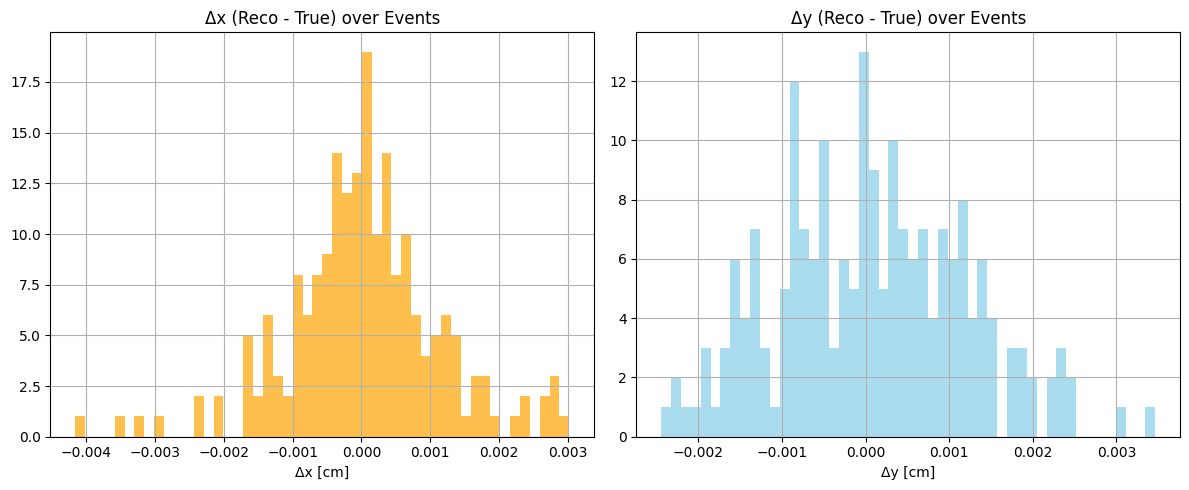

Δx: mean = 0.0000 cm, sigma = 0.0011 cm , DCAX res = 0.0144 cm
Δy: mean = 0.0001 cm, sigma = 0.0011 cm , DCAY res = 0.0141 cm


In [ ]:
# === Plotting ===
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(deltax_events, bins=50, color='orange', alpha=0.7)
ax[0].set_title("Δx (Reco - True) over Events")
ax[0].set_xlabel("Δx [cm]")
ax[0].grid(True)

ax[1].hist(deltay_events, bins=50, color='skyblue', alpha=0.7)
ax[1].set_title("Δy (Reco - True) over Events")
ax[1].set_xlabel("Δy [cm]")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# === Stats ===
print("Δx: mean = {:.4f} cm, sigma = {:.4f} cm".format(np.mean(deltax_events), np.std(deltax_events)), ", DCAX res = {:.4f} cm".format(np.mean(stddevx_events)))
print("Δy: mean = {:.4f} cm, sigma = {:.4f} cm".format(np.mean(deltay_events), np.std(deltay_events)), ", DCAY res = {:.4f} cm".format(np.mean(stddevy_events)))


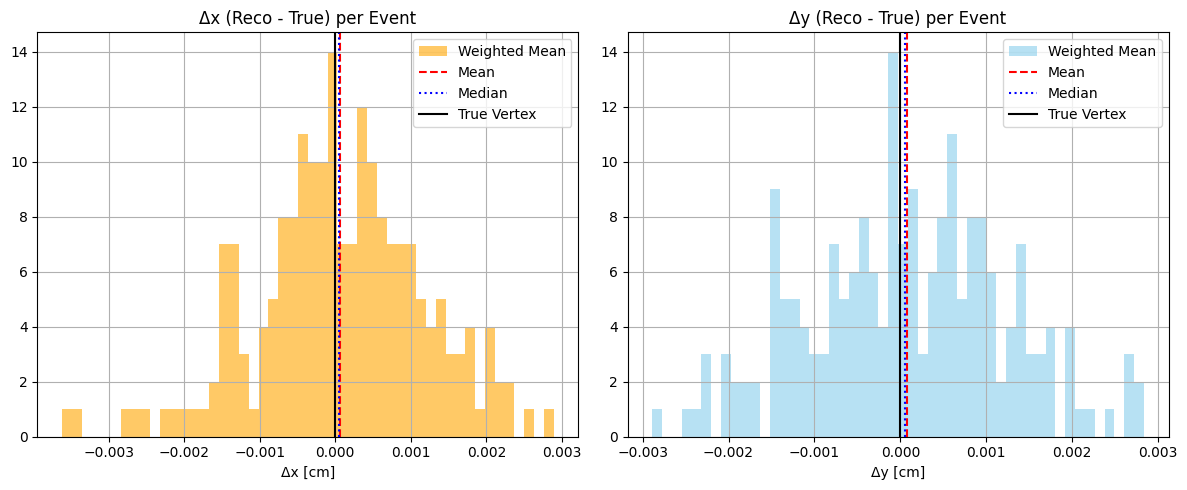

Δx: mean = 0.0001 cm, sigma = 0.0011 cm
Δy: mean = 0.0001 cm, sigma = 0.0012 cm


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Δx
ax[0].hist(deltax_median_events, bins=50, color='orange', alpha=0.6, label='Weighted Mean')
ax[0].axvline(np.mean(deltax_median_events), color='red', linestyle='--', label='Mean')
ax[0].axvline(np.median(deltax_median_events), color='blue', linestyle=':', label='Median')
ax[0].axvline(0, color='black', linestyle='-', label='True Vertex')
ax[0].set_title("Δx (Reco - True) per Event")
ax[0].set_xlabel("Δx [cm]")
ax[0].legend()
ax[0].grid(True)

# Δy
ax[1].hist(deltay_median_events, bins=50, color='skyblue', alpha=0.6, label='Weighted Mean')
ax[1].axvline(np.mean(deltay_median_events), color='red', linestyle='--', label='Mean')
ax[1].axvline(np.median(deltay_median_events), color='blue', linestyle=':', label='Median')
ax[1].axvline(0, color='black', linestyle='-', label='True Vertex')
ax[1].set_title("Δy (Reco - True) per Event")
ax[1].set_xlabel("Δy [cm]")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


# === Stats ===
print("Δx: mean = {:.4f} cm, sigma = {:.4f} cm".format(np.mean(deltax_median_events), np.std(deltax_median_events)))
print("Δy: mean = {:.4f} cm, sigma = {:.4f} cm".format(np.mean(deltay_median_events), np.std(deltay_median_events)))


/tmp/ipykernel_15453/1839997744.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pt_resolution = df.groupby('pt_bin')['delta_p'].mean()
/tmp/ipykernel_15453/1839997744.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pt_std = df.groupby('pt_bin')['delta_p'].std()


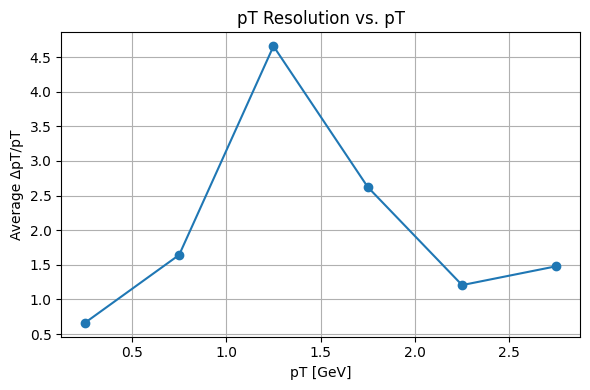

In [ ]:
pt_array = np.array(pt_res)
pt_vals = pt_array[:, 0]
delta_p_vals = pt_array[:, 1]

# Bin in 0.5 GeV intervals
bins = np.arange(0, 3.5, 0.5)
df = pd.DataFrame({'pt': pt_vals, 'delta_p': delta_p_vals})
df['pt_bin'] = pd.cut(df['pt'], bins=bins)

# Compute mean resolution per bin
pt_resolution = df.groupby('pt_bin')['delta_p'].mean()
pt_std = df.groupby('pt_bin')['delta_p'].std()
pt_centers = 0.5 * (bins[:-1] + bins[1:])

# Plot
plt.figure(figsize=(6, 4))
plt.errorbar(pt_centers, pt_std, yerr=0, fmt='o-', capsize=3)
plt.xlabel('pT [GeV]')
plt.ylabel('Average ΔpT/pT')
plt.title('pT Resolution vs. pT')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def generate_tracks(ntracks=500, vertex=(0., 0., 0.0), sigma=0.01):
    x_vtx = np.random.normal(vertex[0], sigma)
    y_vtx = np.random.normal(vertex[1], sigma)
    z_vtx = vertex[2]  # No smearing in Z for now

    hits_layer0 = []
    hits_layer1 = []

    for _ in range(ntracks):
        # pT ~ exponential from 0.1 to 3.0 GeV
        pt = min(np.random.exponential(scale=0.5) + 0.1, 3.0)
        R = 300.0 * pt  # cm, assuming qB = 0.9 T

        # rapidity flat in [-0.5, 0.5] → get theta
        eta = np.random.uniform(-0.5, 0.5)
        theta = 2 * np.arctan(np.exp(-eta))  # radians

        phi0 = np.random.uniform(0, 2 * np.pi)
        
        charge = np.random.choice([-1, 1])  # random charge

        hit_coords = []
        for radius in LAYER_RADII:
            dphi = radius / R
            phi = phi0 + charge * dphi
            x = x_vtx + radius * np.cos(phi)
            y = y_vtx + radius * np.sin(phi)
            z = z_vtx + radius / np.tan(theta)
            hit_coords.append((x, y, z, phi, theta))

        hits_layer0.append(hit_coords[0])
        hits_layer1.append(hit_coords[1])

    return hits_layer0, hits_layer1, (x_vtx, y_vtx, z_vtx)


In [ ]:
def reco_vertex(hits_layer0, hits_layer1, sdphi=SDPHI, sdthe=SDTHE):
    lines_xy = []
    lines_rz = []
    beam_x, beam_y = 0., 0.0

    for h0 in hits_layer0:
        for h1 in hits_layer1:
            x0, y0, z0, *_ = h0
            x1, y1, z1, *_ = h1

            r0 = np.sqrt((x0 - beam_x)**2 + (y0 - beam_y)**2)
            r1 = np.sqrt((x1 - beam_x)**2 + (y1 - beam_y)**2)
            phi0 = np.arctan2(y0 - beam_y, x0 - beam_x)
            phi1 = np.arctan2(y1 - beam_y, x1 - beam_x)

            the0 = np.arctan2(r0, z0)  # assuming z is downstream
            the1 = np.arctan2(r1, z1)

            dphi = abs(phi0 - phi1)
            dtheta = abs(the0 - the1)

            if dphi < sdphi and dtheta < sdthe:
                # --- x-y plane ---
                dx = x0 - x1
                dy = y0 - y1
                if abs(dx) > 1e-6:
                    a_xy = dy / dx
                    b_xy = y0 - a_xy * x0
                    lines_xy.append((a_xy, b_xy))

                # --- r-z plane ---
                r0 = np.sqrt(x0**2 + y0**2)
                r1 = np.sqrt(x1**2 + y1**2)
                dr = r0 - r1
                dz = z0 - z1
                if abs(dr) > 1e-6:
                    a_rz = dz / dr
                    b_rz = z0 - a_rz * r0
                    lines_rz.append((a_rz, b_rz))

    def compute_intersections(lines):
        points = []
        weights = []
        for i in range(len(lines)):
            for j in range(i + 1, len(lines)):
                a1, b1 = lines[i]
                a2, b2 = lines[j]
                delta = a1 - a2
                if abs(delta) < 1e-6:
                    continue
                x = (b2 - b1) / delta
                y = a1 * x + b1
                w = 1.0 / (1.0 + delta**2)  # stable weighting
                points.append((x, y))
                weights.append(w)
        return points, weights

    def avg(points):
        if not points:
            return 0.0, 0.0
        x = np.mean([p[0] for p in points])
        y = np.mean([p[1] for p in points])
        return x, y

    def weighted_avg(points, weights):
        if not points:
            return 0.0, 0.0
        total_w = sum(weights)
        x = sum(x * w for (x, _), w in zip(points, weights)) / total_w
        y = sum(y * w for (_, y), w in zip(points, weights)) / total_w
        return x, y

    # Compute
    points_xy, weights_xy = compute_intersections(lines_xy)
    points_rz, weights_rz = compute_intersections(lines_rz)

    xy_unw = avg(points_xy)
    xy_wgt = weighted_avg(points_xy, weights_xy)
    rz_unw = avg(points_rz)
    rz_wgt = weighted_avg(points_rz, weights_rz)

    return {
        "xy_unw": xy_unw,
        "xy_wgt": xy_wgt,
        "rz_unw": rz_unw,
        "rz_wgt": rz_wgt,
        "pts_xy": points_xy,
        "weights_xy": weights_xy,
        "pts_rz": points_rz,
        "weights_rz": weights_rz
    }



In [ ]:
def plot_intersection_histograms(vtx_result, true_vtx_x, label="X-coordinate"):
    # Extract X-values of intersections and filter them
    x_unweighted = [x for x, _ in vtx_result['pts_xy'] if -0.5 <= x <= 1]  # Filter for range [-0.5, 1]
    x_weighted = [x for (x, _), w in zip(vtx_result['pts_xy'], vtx_result['weights_xy']) if w > 0 and -0.5 <= x <= 1]

    # Compute mean and median
    def stats(arr):
        return np.mean(arr), np.median(arr)

    mean_unw, median_unw = stats(x_unweighted)
    mean_wgt, median_wgt = stats(x_weighted)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # Top: unweighted
    ax1.hist(x_unweighted, bins=500, alpha=0.6, color='gray')
    ax1.axvline(mean_unw, color='green', linestyle='--', label='Mean')
    ax1.axvline(median_unw, color='blue', linestyle=':', label='Median')
    ax1.axvline(true_vtx_x, color='black', linestyle='-', label='True')
    ax1.set_title(f"Unweighted Intersections ({label})")
    ax1.legend()
    ax1.grid(True)

    # Bottom: weighted
    ax2.hist(x_weighted, bins=500, alpha=0.6, color='gray')
    ax2.axvline(mean_wgt, color='green', linestyle='--', label='Mean')
    ax2.axvline(median_wgt, color='blue', linestyle=':', label='Median')
    ax2.axvline(true_vtx_x, color='black', linestyle='-', label='True')
    ax2.set_title(f"Weighted Intersections ({label})")
    ax2.set_xlabel(label)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

True Vertex:      x=-0.0108, y=-0.0096, z=0.0000
Reco XY (unw):    x=0.0075, y=-0.0135
Reco XY (wgt):    x=0.0186, y=-0.0386
Reco Z  (unw):    z=0.0762
Reco Z  (wgt):    z=0.0867


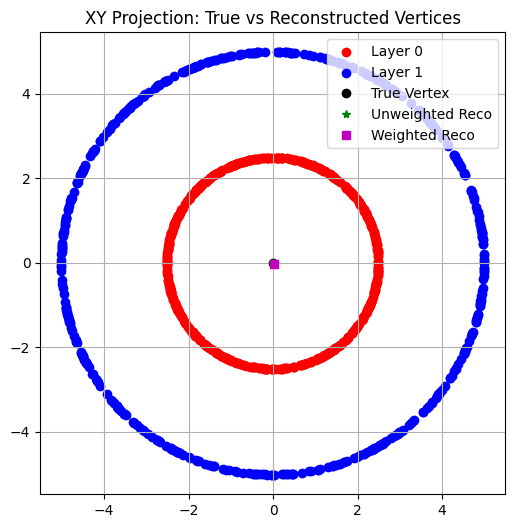

In [ ]:
hits0, hits1, true_vtx = generate_tracks()
vtx_result = reco_vertex(hits0, hits1)

print(f"True Vertex:      x={true_vtx[0]:.4f}, y={true_vtx[1]:.4f}, z={true_vtx[2]:.4f}")
print(f"Reco XY (unw):    x={vtx_result['xy_unw'][0]:.4f}, y={vtx_result['xy_unw'][1]:.4f}")
print(f"Reco XY (wgt):    x={vtx_result['xy_wgt'][0]:.4f}, y={vtx_result['xy_wgt'][1]:.4f}")
print(f"Reco Z  (unw):    z={vtx_result['rz_unw'][1]:.4f}")
print(f"Reco Z  (wgt):    z={vtx_result['rz_wgt'][1]:.4f}")

# Plot XY
plt.figure(figsize=(6, 6))
plt.scatter(*zip(*[(x, y) for (x, y, _, _, _) in hits0]), color='red', label='Layer 0')
plt.scatter(*zip(*[(x, y) for (x, y, _, _, _) in hits1]), color='blue', label='Layer 1')
plt.plot(*true_vtx[:2], 'ko', label='True Vertex')
plt.plot(*vtx_result['xy_unw'], 'g*', label='Unweighted Reco')
plt.plot(*vtx_result['xy_wgt'], 'ms', label='Weighted Reco')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper right')
plt.title("XY Projection: True vs Reconstructed Vertices")
plt.show()


In [ ]:
#%matplotlib widget

from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plot

def plot_3d_hits(hits_layer0, hits_layer1, true_vtx=None, reco_vtx=None):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Extract coordinates
    x0, y0, z0 = zip(*[(x, y, z) for (x, y, z, _, _) in hits_layer0])
    x1, y1, z1 = zip(*[(x, y, z) for (x, y, z, _, _) in hits_layer1])

    ax.scatter(x0, y0, z0, c='r', label='Layer 0', depthshade=True)
    ax.scatter(x1, y1, z1, c='b', label='Layer 1', depthshade=True)

    # True vertex
    if true_vtx:
        ax.scatter(*true_vtx, c='k', marker='o', s=50, label='True Vertex')

    # Reco vertex
    if reco_vtx:
        ax.scatter(*reco_vtx, c='m', marker='^', s=50, label='Reco Vertex')

    ax.set_xlabel('X [cm]')
    ax.set_ylabel('Y [cm]')
    ax.set_zlabel('Z [cm]')
    ax.set_title("3D VTX Hit Map")
    ax.legend()
    plt.tight_layout()
    plt.show()


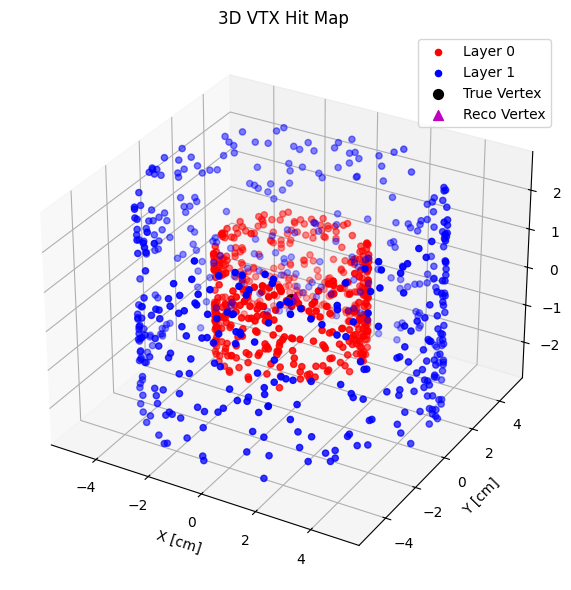

In [ ]:
hits0, hits1, true_vtx = generate_tracks()
vtx_result = reco_vertex(hits0, hits1)
reco3d = (vtx_result['xy_unw'][0], vtx_result['xy_unw'][1], vtx_result['rz_unw'][1])

plot_3d_hits(hits0, hits1, true_vtx=true_vtx, reco_vtx=reco3d)


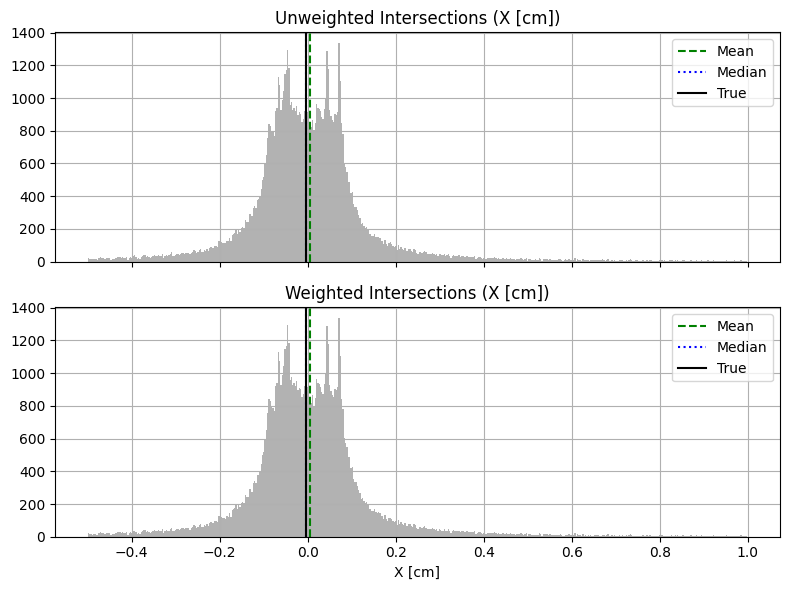

In [ ]:
hits0, hits1, true_vtx = generate_tracks()
vtx_result = reco_vertex(hits0, hits1)

plot_intersection_histograms(vtx_result, true_vtx_x=true_vtx[0], label="X [cm]")

